In [15]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os
import torch

from torch.utils.data import DataLoader

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_split import dagm_patch_get_splits
from src.deep_ad.image import plot_losses, plot_images
from src.deep_ad.model import DeepCNN
from src.deep_ad.save_manager import SaveManager
from src.deep_ad.trainer import Trainer, create_optimizer, PretrainedDict
from src.deep_ad.transforms import create_training_transform, create_validation_transform, normalize_to_mean_std

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Load the configuration
# config = Config(root_dir="..", config_path="../save/checkpoints/7_class_10_1_batch_weights_init/config.yml")
config = Config(root_dir="..", config_path="../default_config.yml")
config.batch_norm = True
config.train_classes = [10]

### Test the trainer

In [17]:
# Load the datasets
train_transform = create_training_transform(config)
val_transform = create_validation_transform(config)
train_dataset, val_dataset, test_dataset = dagm_patch_get_splits(
    config, train_transform, val_transform, classes=config.train_classes
)

In [18]:
# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

Create a new model

In [5]:
# Load the model
model = DeepCNN(config).to(config.device)
optimizer = create_optimizer(model, config)
model_num_params = sum(p.numel() for p in model.parameters())
print(f"Model has {model_num_params:,} parameters")
pretrained_dict = None

Model has 1,447,713 parameters


OR load a pretrained model

In [24]:
run_name = "13-7_class_10_1_batch_in_out_norm_lambda_31_32"
checkpoint_name = "best"
model = DeepCNN(config).to(config.device)
optimizer = create_optimizer(model, config)
checkpoint_path = SaveManager.get_checkpoint_path(config, run_name, name=checkpoint_name)
model, optimizer, train_losses, val_losses, epoch = SaveManager.load_checkpoint(
    model,
    optimizer,
    path=checkpoint_path,
    
)
pretrained_dict: PretrainedDict = {"epoch": epoch, "train_losses": train_losses, "val_losses": val_losses}

Checkpoint loaded from '..\save\checkpoints\13-7_class_10_1_batch_in_out_norm_lambda_31_32\best.pt'.


In [25]:
# Create the trainer
run_name = f"13-7_class_10_1_batch_in_out_norm_lambda_31_32"
print(f"Run name: {run_name}\n")
train_epochs = 200
limit_batches = 1
save_epochs = [150, 200]
config.train_epochs = train_epochs
config.loss_Lambda = 31 / 32
print(config)
trainer = Trainer(
    config,
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    run_name=run_name,
    train_epochs=train_epochs,
    limit_batches=limit_batches,
    save_epochs=save_epochs,
    pretrained_dict=pretrained_dict or None,
)

Run name: 13-7_class_10_1_batch_in_out_norm_lambda_31_32

Datasets:
dagm_lengths: [0.8, 0.1, 0.1]
raw_patch_size: 176
patch_size: 128
ppi: 4
patches_iou_threshold: 0.05

PyTorch:
seed: 42
device: cuda

Model:
batch_norm: True
init_weights: True

Training:
batch_size: 32
loss_type: l1_norm
loss_Lambda: 0.96875
loss_N: 16384
optim_lr: 0.0002
optim_adam_betas: (0.9, 0.999)
optim_adam_eps: 1e-08
train_epochs: 200
train_classes: [10]


Resuming training from epoch 116.
	Batch   1/100: Loss 0.000216
Epoch 117/200: Train Loss 0.000216, Val Loss 0.000214, time 20.518 s
Checkpoint saved at '..\save\checkpoints\13-7_class_10_1_batch_in_out_norm_lambda_31_32\best.pt'
	Batch   1/100: Loss 0.000218
Epoch 118/200: Train Loss 0.000218, Val Loss 0.000214, time 13.525 s
	Batch   1/100: Loss 0.000210
Epoch 119/200: Train Loss 0.000210, Val Loss 0.000212, time 12.982 s
Checkpoint saved at '..\save\checkpoints\13-7_class_10_1_batch_in_out_norm_lambda_31_32\best.pt'
	Batch   1/100: Loss 0.000215
Epoch 120/200: Train Loss 0.000215, Val Loss 0.000210, time 13.002 s
Checkpoint saved at '..\save\checkpoints\13-7_class_10_1_batch_in_out_norm_lambda_31_32\best.pt'
	Batch   1/100: Loss 0.000213
Epoch 121/200: Train Loss 0.000213, Val Loss 0.000210, time 12.139 s
Checkpoint saved at '..\save\checkpoints\13-7_class_10_1_batch_in_out_norm_lambda_31_32\best.pt'
	Batch   1/100: Loss 0.000207
Epoch 122/200: Train Loss 0.000207, Val Loss 0.000212

KeyboardInterrupt: 

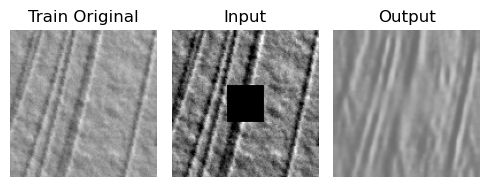

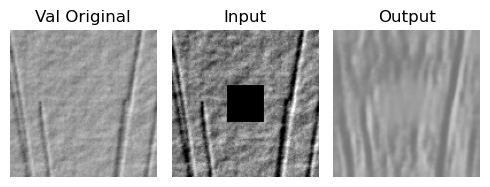

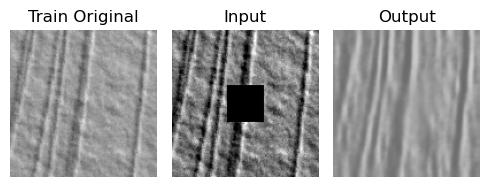

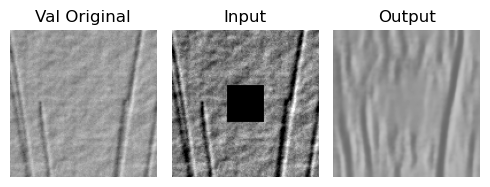

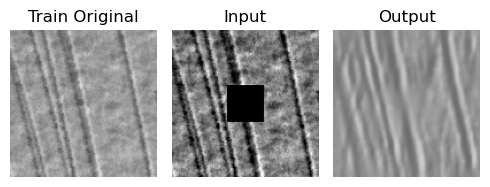

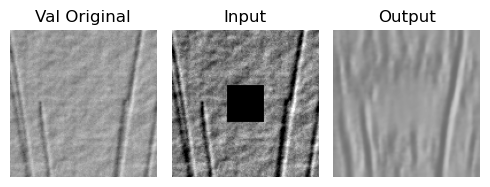

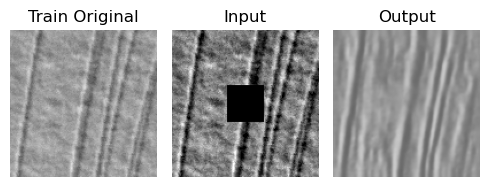

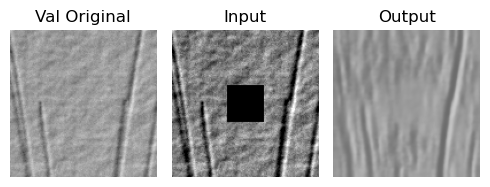

In [26]:
# Start training
%matplotlib inline
train_losses, val_losses = trainer.train(plot_train=True, plot_val=True)

In [27]:
# Clear cache after training
torch.cuda.empty_cache()

### Plots

In [9]:
# Load the best model
model_best = DeepCNN(config).to(config.device)
optimizer_best = create_optimizer(model_best, config)
run_name = "13-7_class_10_1_batch_in_out_norm_lambda_31_32"
checkpoint_name = "epoch_100"
save_dir = os.path.join(config.root_dir, "save", "plots", run_name)
model_best, optimizer_best, train_losses, val_losses, epoch = SaveManager.load_checkpoint(
    model=model_best,
    optimizer=optimizer_best,
    path=SaveManager.get_checkpoint_path(config, run_name=run_name, name=checkpoint_name),
)
print(f"Loading best model for run {run_name}, checkpoint {checkpoint_name}")
print(f"Epoch: {epoch}")
print(f"Train loss: last={train_losses[-1]:.6f}, best={min(train_losses):.6f}")
print(f"Val loss: last={val_losses[-1]:.6f}, best={min(val_losses):.6f}")

Checkpoint loaded from '..\save\checkpoints\13-7_class_10_1_batch_in_out_norm_lambda_31_32\epoch_100.pt'.
Loading best model for run 13-7_class_10_1_batch_in_out_norm_lambda_31_32, checkpoint epoch_100
Epoch: 99
Train loss: last=0.000216, best=0.000214
Val loss: last=0.000226, best=0.000222


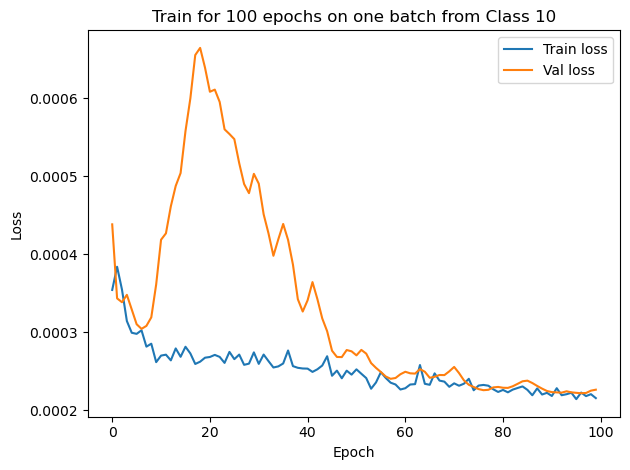

In [10]:
%matplotlib inline
# Plot the losses
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plot_losses(
    torch.asarray(train_losses), 
    torch.asarray(val_losses), 
    title=f"Train for {config.train_epochs} epochs on one batch from Class 10", 
    save_path=os.path.join(save_dir, f"{checkpoint_name}_losses.png"),
)

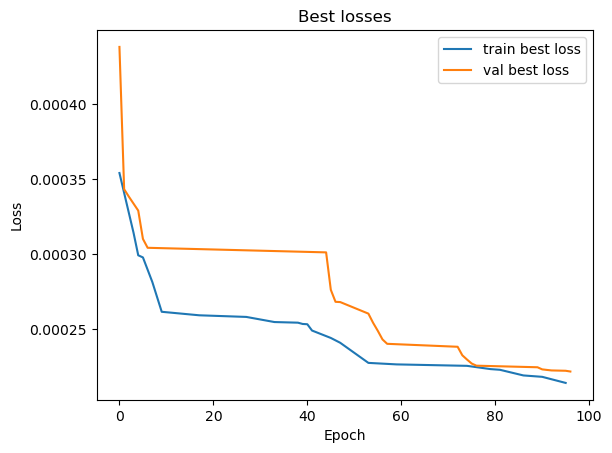

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

losses_minimum = np.minimum.accumulate(train_losses)
change_indices = (np.roll(losses_minimum, 1) != losses_minimum).nonzero()[0]
best_losses = np.array(train_losses)[change_indices]
val_losses_minimum = np.minimum.accumulate(val_losses)
val_change_indices = (np.roll(val_losses_minimum, 1) != val_losses_minimum).nonzero()[0]
best_val_losses = np.array(val_losses)[val_change_indices]

plt.plot(change_indices, best_losses, label="train best loss")
plt.plot(val_change_indices, best_val_losses, label="val best loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.title("Best losses")
plt.savefig(os.path.join(save_dir, f"{checkpoint_name}_best_losses.png"), dpi=1000)
plt.show()

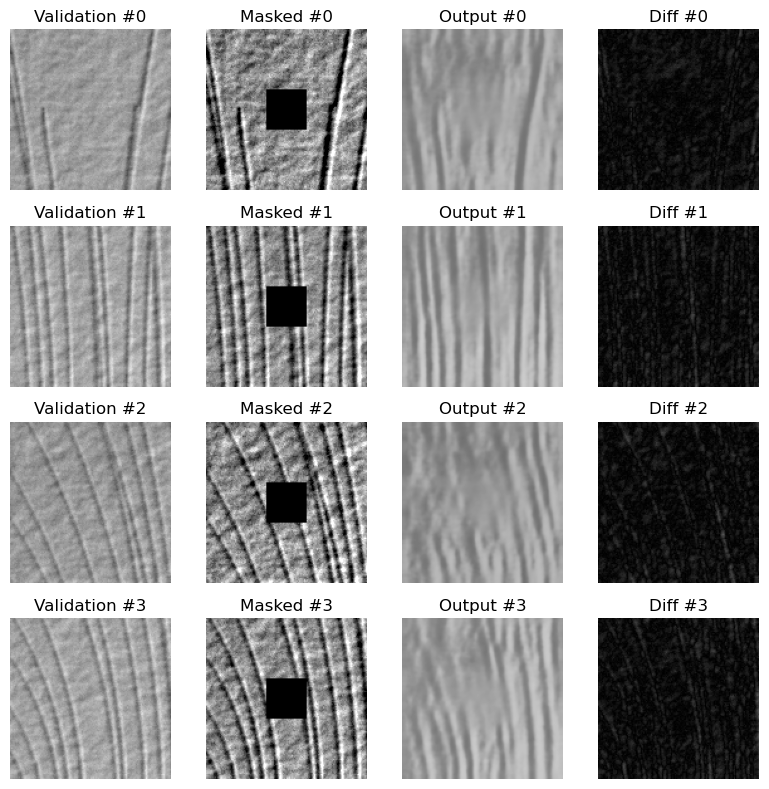

In [14]:
%matplotlib inline
def flatten(xs):
    return [x for ys in xs for x in ys]


n_samples: int = 4
dataset_type = "validation"
images, keys = next(iter(train_dataloader if dataset_type == "train" else val_dataloader))
input_images = []
masked_inputs = []
outputs = []
for i in range(n_samples):
    image = images[i]
    input_images.append(image.squeeze().detach().cpu().numpy())
    input = image.unsqueeze(0).to(config.device)
    input = normalize_to_mean_std(input, mean=0.5267019737681685, std=0.19957033073362934)
    input[:, :, 48:80, 48:80] = 0
    masked_inputs.append(input.squeeze().detach().cpu().numpy())
    output = model_best(input)
    output = normalize_to_mean_std(
        output.cpu(), image.mean(dim=(-2, -1), keepdim=True), image.std(dim=(-2, -1), keepdim=True)
    )
    outputs.append(output.squeeze().detach().cpu().numpy())
diff = np.abs(np.array(input_images) - np.array(outputs))
titles = flatten([[f"{dataset_type.capitalize()} #{i}", f"Masked #{i}", f"Output #{i}", f"Diff #{i}"] for i in range(4)])
plot_images(
    flatten(list(zip(input_images, masked_inputs, outputs, diff))),
    titles,
    rows=n_samples,
    cols=4,
    figsize=(4 * 2, n_samples * 2),
    show=False,
    range="01",
)
plt.savefig(os.path.join(save_dir, f"{checkpoint_name}_{dataset_type}_outputs.png"), dpi=1000)
plt.show()

Checkpoint loaded from '..\save\checkpoints\13_class_10_1_batch_winit_bn_inout_norm_all\epoch_100.pt'.
Checkpoint loaded from '..\save\checkpoints\13-6_class_10_1_batch_in_out_norm_lambda_14_15\epoch_100.pt'.
13_class_10_1_batch_winit_bn_inout_norm_all/epoch_100:
train last: 0.000228, train best: 0.000228, val last: 0.000231, val best: 0.000230
13-6_class_10_1_batch_in_out_norm_lambda_14_15/epoch_100:
train last: 0.000237, train best: 0.000223, val last: 0.000244, val best: 0.000240


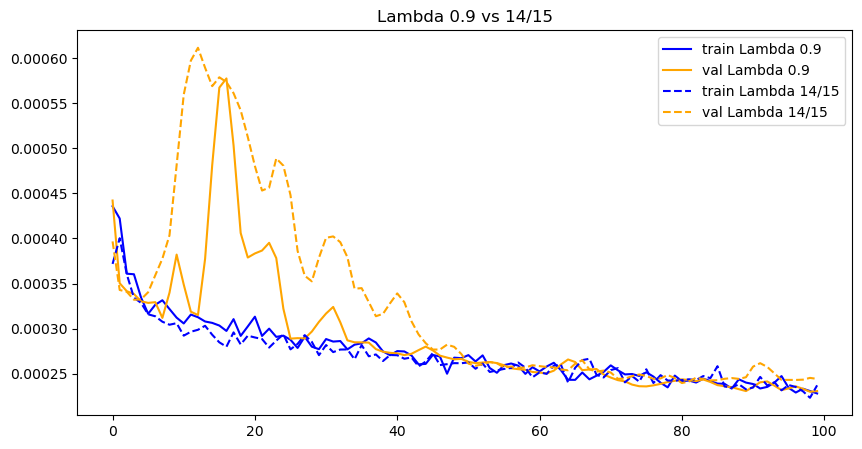

In [30]:
config.batch_norm = True
model1 = DeepCNN(config, old_architecture=False).to(config.device)
optimizer1 = create_optimizer(model1, config)
run_name1 = "13_class_10_1_batch_winit_bn_inout_norm_all"
checkpoint_name1 = "epoch_100"
model1, optimizer1, train_losses1, val_losses1, epoch1 = SaveManager.load_checkpoint(
    model=model1,
    optimizer=optimizer1,
    path=SaveManager.get_checkpoint_path(config, run_name=run_name1, name=checkpoint_name1),
)

config.batch_norm = True
model2 = DeepCNN(config, old_architecture=False).to(config.device)
optimizer2 = create_optimizer(model2, config)
run_name2 = "13-6_class_10_1_batch_in_out_norm_lambda_14_15"
checkpoint_name2 = "epoch_100"
model2, optimizer2, train_losses2, val_losses2, epoch2 = SaveManager.load_checkpoint(
    model=model2,
    optimizer=optimizer2,
    path=SaveManager.get_checkpoint_path(config, run_name=run_name2, name=checkpoint_name2),
)

print(f"{run_name1}/{checkpoint_name1}:")
print(
    f"train last: {train_losses1[-1]:.6f}, train best: {min(train_losses1):.6f}, val last: {val_losses1[-1]:.6f}, val best: {min(val_losses1):.6f}"
)
print(f"{run_name2}/{checkpoint_name2}:")
print(
    f"train last: {train_losses2[-1]:.6f}, train best: {min(train_losses2):.6f}, val last: {val_losses2[-1]:.6f}, val best: {min(val_losses2):.6f}"
)

import matplotlib.pyplot as plt

label1 = "Lambda 0.9"
label2 = "Lambda 14/15"
plt.figure(figsize=(10, 5))
plt.plot(train_losses1, label=f"train {label1}", color="blue")
plt.plot(val_losses1, label=f"val {label1}", color="orange")
plt.plot(train_losses2, label=f"train {label2}", color="blue", linestyle="--")
plt.plot(val_losses2, label=f"val {label2}", color="orange", linestyle="--")
plt.legend()
plt.title("Lambda 0.9 vs 14/15")
plt.show()